**Table of contents**<a id='toc0_'></a>    
- 1. [Import libraries](#toc1_)    
- 2. [Download data](#toc2_)    
- 3. [Read and display data](#toc3_)    
- 4. [Matrix Factorization model using alternating least squares](#toc4_)    
  - 4.1. [Results](#toc4_1_)    
- 5. [Matrix Factorization model using deep neural networks](#toc5_)    
  - 5.1. [Using side features in addition to utility matrix](#toc5_1_)    
    - 5.1.1. [Retrieve track features from spotify api](#toc5_1_1_)    
    - 5.1.2. [List playlist titles](#toc5_1_2_)    
    - 5.1.3. [Prepare rating list](#toc5_1_3_)    
  - 5.2. [Extending user/item models](#toc5_2_)    
    - 5.2.1. [User model considering playlist name](#toc5_2_1_)    
    - 5.2.2. [Item model considering track features](#toc5_2_2_)    
  - 5.3. [Combine user and item models](#toc5_3_)    
    - 5.3.1. [Using activation function](#toc5_3_1_)    
  - 5.4. [Results](#toc5_4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Import libraries](#toc0_)

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.sparse import coo_matrix
from implicit.gpu.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight
from implicit import evaluation
from tqdm import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_recommenders as tfrs

/home/eandriolo/miniconda3/envs/rs/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-19 16:50:55.068374: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 16:50:55.706607: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 2. <a id='toc2_'></a>[Download data](#toc0_)

download the Spotify Million Playlist Dataset from https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge

# 3. <a id='toc3_'></a>[Read and display data](#toc0_)


playlists are extracted in the `data` folder

In [2]:
mdp_dir = os.path.join(os.getcwd(), 'mdp/')

if not os.path.isdir(mdp_dir):
    with ZipFile('spotify_million_playlist_dataset.zip', 'r') as zObject:
        zObject.extractall(
            path=mdp_dir)

slices_list = sorted(os.listdir('mdp/data'))
len(slices_list)

1

we take the first 1*1000=1000 playlist, and compute the number of unique songs

In [3]:
number_of_files_parsed = 1
items = set()
users = []
playlist_titles = []
for slice in slices_list[:number_of_files_parsed]:
    with open(os.path.join(os.getcwd(),'mdp/data',slice),'r') as f:
        js = json.load(f)
        playlist_titles.extend([pl['name'] for pl in js['playlists']])
        users.extend([[tl['track_uri'][14:] for tl in i['tracks']] for i in js['playlists']])
        items.update(set([tr['track_uri'][14:]  for pl in js['playlists'] for tr in pl['tracks']]))
print(len(users),len(items))

1000 34443


In [4]:
ratings_csv_name = 'util_matrix.csv'
if os.path.exists(os.path.join(os.getcwd(), ratings_csv_name)):
    util_matrix = pd.read_csv(ratings_csv_name, index_col=0)
else:
    util_matrix = pd.DataFrame(columns=list(items))
    for i,lst in enumerate(tqdm(users)):
        util_matrix.loc[len(util_matrix)]=0
        util_matrix.iloc[len(util_matrix)-1,np.where(util_matrix.columns.isin(lst))] = 1
        filename = str(len(users))+'x'+str(len(items))+'_part_'+str(i)+'.csv'
        util_matrix.rename(index={len(util_matrix)-1:i},inplace=True)
    util_matrix.to_csv(ratings_csv_name)
print(f"Number of rated songs: {util_matrix.values.sum()}")
display(util_matrix)

100%|██████████| 1000/1000 [00:38<00:00, 25.67it/s]


Number of rated songs: 66721


,6yR4stohNeRnzSatHaUUVv,1B17jo7XD3lJ9AtrdE9kUd,5rwxsHLK1q9fPJFyyqJmP1,46l7fOJggsNqrNPJeFk0og,6sHsPrcjMZ7wJEhegICUQP,2dMjy70ufAcxK2ib7pEW4n,4FtGIIBAi0xFRpO0Z0kbcY,7jdwRG5XVcb8A3yQ3bXv8B,0KwR2yIvknqi1V9BUFmZ2i,6waqLPcT6ruMhmd36OhmFO,...,0B0y2FImat9j9MJTNRZWfW,2HQerWGTwJfTtOlJ3OA2Yn,0c5QKViNmTWyXJODcruNsr,1uUyPBaiAtHsTDtY2vvGMS,38KSxMVReXETn6MRZPgEq3,40oKW22ZNNkEdZLJTScaQI,4RQFyVdJpn87nbz4pUGCRX,2FgkwIXC52sHCbqVL8jE41,7LfTMbUWpmsucYcU9aLDM5,3VPBqHUd17ZvEgabW9ZOUU
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
print("Matrix sparsity is " + str(format(np.count_nonzero(util_matrix) / (util_matrix.shape[0]*util_matrix.shape[1]),'%')))

Matrix sparsity is 0.193714%


rank the 30 most popular songs

In [6]:
pop_songs = util_matrix[util_matrix!=0].count(axis=0)

pop_songs = pd.DataFrame( data= pop_songs.sort_values(ascending=False)[:30],  columns =['Nr. of playlists the song appears'])
display(pop_songs)

,Nr. of playlists the song appears
7KXjTSCq5nL1LoYtL7XAwS,52
1xznGGDReH1oQq0xzbwXa3,50
7yyRTcZmCiyzzJlNzGC9Ol,49
7BKLCZ1jbUBVqRi2FVlTVw,45
3a1lNhkSLSkpJE4MSHpDu9,44
0QsvXIfqM0zZoerQfsI9lm,41
6O6M7pJLABmfBRoGZMu76Y,39
2EEeOnHehOozLq4aS0n6SL,39
0VgkVdmE4gld66l8iyGjgx,38
0SGkqnVQo9KPytSri1H6cF,38


# 4. <a id='toc4_'></a>[Matrix Factorization model using alternating least squares](#toc0_)


In [7]:
# transorfm in scipy coordinate sparse matrix
util_matrix_sparse = coo_matrix(util_matrix.values).tocsr()

# weight for popular items
ratings_sparse_weighted =  bm25_weight(util_matrix_sparse, K1=100, B=0.8)

# split train/test
train,test = evaluation.train_test_split(util_matrix_sparse, train_percentage=0.8)

## 4.1. <a id='toc4_1_'></a>[Results](#toc0_)

In [8]:
results=[]
for i in range(50):
    print('Alpha = '+str(i))
    model = AlternatingLeastSquares(factors=64, regularization=0.05, alpha=i)
    model.fit(train, show_progress=False)
    results.append(evaluation.precision_at_k(model,train,test,show_progress=False, K=10))
best_res = np.argmax(results)
precision_mf = results[best_res]
print(f"Highest precision {precision_mf:.4f} for α = {best_res}")

Alpha = 0
Alpha = 1
Alpha = 2
Alpha = 3
Alpha = 4
Alpha = 5
Alpha = 6
Alpha = 7
Alpha = 8
Alpha = 9
Alpha = 10
Alpha = 11
Alpha = 12
Alpha = 13
Alpha = 14
Alpha = 15
Alpha = 16
Alpha = 17
Alpha = 18
Alpha = 19
Alpha = 20
Alpha = 21
Alpha = 22
Alpha = 23
Alpha = 24
Alpha = 25
Alpha = 26
Alpha = 27
Alpha = 28
Alpha = 29
Alpha = 30
Alpha = 31
Alpha = 32
Alpha = 33
Alpha = 34
Alpha = 35
Alpha = 36
Alpha = 37
Alpha = 38
Alpha = 39
Alpha = 40
Alpha = 41
Alpha = 42
Alpha = 43
Alpha = 44
Alpha = 45
Alpha = 46
Alpha = 47
Alpha = 48
Alpha = 49
Highest precision 0.0702 for α = 37


# 5. <a id='toc5_'></a>[Matrix Factorization model using deep neural networks](#toc0_)

## 5.1. <a id='toc5_1_'></a>[Using side features in addition to utility matrix](#toc0_)

### 5.1.1. <a id='toc5_1_1_'></a>[Retrieve track features from spotify api](#toc0_)

download tracks data from https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

In [9]:
api_download_dir = os.path.join(os.getcwd(), 'api_download/')
if not os.path.isdir(api_download_dir):
    os.makedirs(api_download_dir)
    BATCH_SIZE = 50
    OAUTH_TOKEN = "BQBvDlr6Qw3UzC6rQVtOAVXHd2eZkP84oqo8NODG-ogeY0H3WvfGXaWcq1ssBq6s7bjdQLwbTLQ3d0FAv9GoS"+\
                    "-7vRDCgt956k-MO8vMR0-2p0Nx3VyOJxWPzQ4KFhAiBun7GuwY5L948wJ_2JDm74l9sfrm5ryX41vBqaicNrzQROQ"
    chunks = (len(items) - 1) // BATCH_SIZE + 1
    for i in range(chunks):
        batch = ','.join(list(items)[i*BATCH_SIZE:(i+1)*BATCH_SIZE])
        filename = 'chunck_'+str(i)+'.json'  
        !curl -X "GET" "https://api.spotify.com/v1/audio-features?ids="+{batch} -H "Accept: application/json" -H "Content-Type: application/json" \
        -H "Authorization: Bearer +{OAUTH_TOKEN} | jq --raw-output  > {filename}      
        ! mv chunck*.json api_download

In [10]:
track_features_csv_name = 'track_features.csv'

if os.path.exists(os.path.join(os.getcwd(), track_features_csv_name)):
    track_features = pd.read_csv(track_features_csv_name, index_col=0)
else:
    track_features = pd.DataFrame(columns=['speechiness','tempo'])
    for chunck in tqdm(os.listdir('api_download')):
        with open(os.path.join(os.getcwd(),'api_download',chunck,),'r') as s:
            for i in json.load(s)['audio_features']:
                if i:
                    track_features.loc[len(track_features)]= pd.Series(i, index=track_features.columns).T
                    track_features.rename(index={len(track_features)-1:i['id']},inplace=True)
    # 33754 < 34443 because of nulls
    track_features.to_csv(track_features_csv_name)
display(track_features)

  0%|          | 2/689 [00:00<00:34, 19.83it/s]

100%|██████████| 689/689 [02:52<00:00,  3.99it/s]


,speechiness,tempo
0LXfdDKFrHSlRmOXJnhBar,0.0371,149.088
7Gx0xy1SgKIPB17LigTlta,0.0732,123.96
47muNlVTjDtQfyUqDaiFlN,0.0327,140.012
31k336IbmnyKcfRxdMYVRU,0.141,85.974
5Rv2Qybimpsp9hzFnMQBYN,0.029,160.019
...,...,...
1FnItzXv96rXVILRuDfedz,0.0678,138.114
0IIRQLWP8BAgVIr1EfQ7WW,0.0305,115.013
5O3fUsQQBFxW8SH1kHthDH,0.0304,67.604
2BndJYJQ17UcEeUFJP5JmY,0.0638,136.028


### 5.1.2. <a id='toc5_1_2_'></a>[List playlist titles](#toc0_)

In [11]:
playlist_titles

['Throwbacks',
 'Awesome Playlist',
 'korean ',
 'mat',
 '90s',
 'Wedding',
 'I Put A Spell On You',
 '2017',
 'BOP',
 'old country ',
 'abby ',
 'VIBE',
 'relax',
 'sleep',
 "90's ",
 'New Songs',
 'slow hands',
 "Mom's playlist",
 'SARAH',
 'melancholy',
 'mixtape',
 'Sad Songs',
 "fall '17",
 '✔️',
 'Twenty one pilots',
 'run it',
 'Winter 2014',
 'smooth ',
 'Yeet',
 'groovy',
 'Garage Rock',
 'Running 2.0',
 'acoustic',
 'morning',
 'good good',
 'Good Vibes',
 ' indie rock',
 'Hits',
 'tb',
 'Country',
 '2020',
 'Belters',
 "Road Trippin'",
 'Country',
 'taylor swift',
 'angst',
 'Running 2',
 'Spring 2016',
 'Country',
 'Gospel',
 'SB',
 'Kevin',
 'Christmas',
 'NB',
 'Smooth Jazz',
 'Tennessee ',
 'funky',
 'spring 16',
 'Gates',
 'Favorite Songs',
 'Ski',
 'Country',
 'hype',
 'Awesome Mix',
 'Elizabeth',
 'PlayStation',
 'Ashley',
 'chill',
 'xx',
 'art class',
 'Random Tunes',
 'boat',
 'spanish jams',
 'new',
 'CR',
 'Run!!',
 "winter '17",
 'Workout',
 'Traps ',
 'Dope',
 

### 5.1.3. <a id='toc5_1_3_'></a>[Prepare rating list](#toc0_)

we consider only ratings having tracks features

In [12]:
ratings = []
for user in util_matrix.index:
    for item in np.where(util_matrix.transpose()[user]==1)[0]:
        track = util_matrix.columns[item]
        if track in track_features.index:
            rating = {'user_id': user, 'playlist_title': playlist_titles[user], 'track_id': track, 'speechiness': track_features.loc[track][0], 'tempo': track_features.loc[track][1]}
            ratings.append(rating)
print(f"Number of ratings: {len(ratings)}")

Number of ratings: 65227


convert to Tensorflow Dataset before feeding into the models

In [13]:
ratings = tf.data.Dataset.from_tensor_slices(pd.DataFrame.from_dict(ratings).astype({"user_id": str}).to_dict(orient="list"))
next(iter(ratings))

2023-07-19 16:55:03.581457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5242 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5
2023-07-19 16:55:03.582065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9458 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5


{'user_id': <tf.Tensor: shape=(), dtype=string, numpy=b'0'>,
 'playlist_title': <tf.Tensor: shape=(), dtype=string, numpy=b'Throwbacks'>,
 'track_id': <tf.Tensor: shape=(), dtype=string, numpy=b'1kusepF3AacIEtUTYrw4GV'>,
 'speechiness': <tf.Tensor: shape=(), dtype=float32, numpy=0.222>,
 'tempo': <tf.Tensor: shape=(), dtype=float32, numpy=172.247>}

## 5.2. <a id='toc5_2_'></a>[Extending user/item models](#toc0_)

### 5.2.1. <a id='toc5_2_1_'></a>[User model considering playlist name](#toc0_)

In [14]:
title_text = tf.keras.layers.TextVectorization()
title_text.adapt(playlist_titles)

user_id_lookup = tf.keras.layers.StringLookup()
user_id_lookup.adapt(ratings.map(lambda x: x['user_id']))

In [15]:
class UserModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()



    self.user_id_lookup = user_id_lookup
    self.user_embedding = tf.keras.layers.Embedding(user_id_lookup.vocabulary_size(), 32)

    max_tokens=10000
    self.title_text_embedding = tf.keras.Sequential([
      title_text,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

  def call(self, inputs):

    return tf.concat([
      self.user_embedding(self.user_id_lookup(inputs['user_id'])),
      self.title_text_embedding((inputs['playlist_title'])),
      ], axis=1)

### 5.2.2. <a id='toc5_2_2_'></a>[Item model considering track features](#toc0_)

In [16]:
track_id_lookup = tf.keras.layers.StringLookup()
track_id_lookup.adapt(ratings.map(lambda x: x['track_id']))

speechiness_normalization = tf.keras.layers.Normalization(axis=None)
speechiness_normalization.adapt(ratings.map(lambda x: x['speechiness']))

tempo_normalization = tf.keras.layers.Normalization(axis=None)
tempo_normalization.adapt(ratings.map(lambda x: x['tempo']))

In [17]:
class ItemModel(tf.keras.Model):
  
  def __init__(self):
    super().__init__()



    self.track_id_embedding = tf.keras.Sequential([
    track_id_lookup,
    tf.keras.layers.Embedding(track_id_lookup.vocabulary_size(), 32)
    ])

    self.speechiness_normalization = speechiness_normalization
    self.tempo_normalization = tempo_normalization

  def call(self, inputs):
    return tf.concat([

      self.track_id_embedding(inputs['track_id']),
      tf.reshape(self.speechiness_normalization(inputs['speechiness']), (-1,1)),
      tf.reshape(self.tempo_normalization(inputs['tempo']), (-1,1)),
    ], axis=1)

## 5.3. <a id='toc5_3_'></a>[Combine user and item models](#toc0_)

retrieval task is a keras layer with default loss function Categorical Cross Entropy

reference: https://www.tensorflow.org/recommenders/api_docs/python/tfrs/tasks/Retrieval

In [18]:
class SpotiLinearModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      UserModel(),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential([
      ItemModel(),
      tf.keras.layers.Dense(32)
    ])

    metrics = tfrs.metrics.FactorizedTopK(
      candidates=ratings.batch(128).map(self.candidate_model)
    )

    self.task = tfrs.tasks.Retrieval(
      metrics=metrics,
      batch_metrics=[tf.keras.metrics.Precision(top_k=10)]
      )

  def compute_loss(self, features, training=False):

    query_embeddings = self.query_model(features)
    candidate_embeddings = self.candidate_model(features)

    return self.task(query_embeddings, candidate_embeddings)

In [19]:
TRAIN_SPLIT = 0.8
BATCH_SIZE = 512
EPOCHS=100

train_len = round(len(ratings) * TRAIN_SPLIT)
tf.random.set_seed(42)
shuffled = ratings.shuffle(len(ratings), seed=42, reshuffle_each_iteration=False)
train = shuffled.take(train_len).batch(BATCH_SIZE)
test = shuffled.skip(train_len).batch(BATCH_SIZE)

In [20]:
model = SpotiLinearModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

output_dir_linear = 'checkpoints_linear'
checkpoint_dir = Path(output_dir_linear)
checkpoint_path = Path(output_dir_linear)/'cp-{epoch:03d}.ckpt'
ckpt = tf.train.Checkpoint()
ckpt_manager = tf.train.CheckpointManager(
    ckpt, checkpoint_dir, max_to_keep=1)
start_epoch = 0
if checkpoint_dir.exists():
    start_epoch = int(
        ckpt_manager.latest_checkpoint.split('-')[-1].split('.')[-2])
    model.load_weights(ckpt_manager.latest_checkpoint)
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
)

history_linear = model.fit(train,
    epochs=EPOCHS,    
    validation_data=test,
    validation_freq=5,
    initial_epoch=start_epoch,
    callbacks=[model_checkpoint_callback]
)


Epoch 1/100


2023-07-19 16:57:19.294555: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff7c0064100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-19 16:57:19.294599: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-07-19 16:57:19.294614: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-07-19 16:57:19.300773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-19 16:57:19.453481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-07-19 16:57:19.512068: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-07-19 16:57:19.573825: I ./tensorflow/comp

102/102 [==============================] - ETA: 0s - precision: 0.0064 - factorized_top_k/top_1_categorical_accuracy: 0.0027 - factorized_top_k/top_5_categorical_accuracy: 0.0030 - factorized_top_k/top_10_categorical_accuracy: 0.0036 - factorized_top_k/top_50_categorical_accuracy: 0.0074 - factorized_top_k/top_100_categorical_accuracy: 0.0112 - loss: 3066.6991 - regularization_loss: 0.0000e+00 - total_loss: 3066.6991
Epoch 1: saving model to checkpoints_linear/cp-001.ckpt
102/102 [==============================] - 50s 469ms/step - precision: 0.0064 - factorized_top_k/top_1_categorical_accuracy: 0.0027 - factorized_top_k/top_5_categorical_accuracy: 0.0030 - factorized_top_k/top_10_categorical_accuracy: 0.0036 - factorized_top_k/top_50_categorical_accuracy: 0.0074 - factorized_top_k/top_100_categorical_accuracy: 0.0112 - loss: 3062.8051 - regularization_loss: 0.0000e+00 - total_loss: 3062.8051
Epoch 2/100
102/102 [==============================] - ETA: 0s - precision: 0.0247 - factorized

In [21]:
test_precision_linear = history_linear.history['val_precision']
print(f"Precision @ K=10 (test): {test_precision_linear[-1]:.4f}.")

Precision @ K=10 (test): 0.0113.


### 5.3.1. <a id='toc5_3_1_'></a>[Using activation function](#toc0_)

In [22]:
class SpotiReluModel(tfrs.models.Model):

  def __init__(self):
    super().__init__()
    self.query_model = tf.keras.Sequential([
      UserModel(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32)
    ])
    self.candidate_model = tf.keras.Sequential([
      ItemModel(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(32)
    ])

    metrics = tfrs.metrics.FactorizedTopK(
      candidates=ratings.batch(128).map(self.candidate_model)
    )

    self.task = tfrs.tasks.Retrieval(
      metrics=metrics,
      batch_metrics=[tf.keras.metrics.Precision(top_k=10)]
      )

  def compute_loss(self, features, training=False):

    query_embeddings = self.query_model(features)
    candidate_embeddings = self.candidate_model(features)

    return self.task(query_embeddings, candidate_embeddings)

In [24]:
model = SpotiReluModel()
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

output_dir_relu = 'checkpoints_relu'
checkpoint_dir = Path(output_dir_relu)
checkpoint_path = Path(output_dir_relu)/'cp-{epoch:03d}.ckpt'
ckpt = tf.train.Checkpoint()
ckpt_manager = tf.train.CheckpointManager(
    ckpt, checkpoint_dir, max_to_keep=1)
start_epoch = 0
if checkpoint_dir.exists():
    start_epoch = int(
        ckpt_manager.latest_checkpoint.split('-')[-1].split('.')[-2])
    model.load_weights(ckpt_manager.latest_checkpoint)
    print("Restored from {}".format(ckpt_manager.latest_checkpoint))

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    verbose=1
)

history_relu = model.fit(
    train, 
    epochs=EPOCHS,    
    validation_data=test,
    validation_freq=5,
    initial_epoch=start_epoch,
    callbacks=[model_checkpoint_callback]
)


Epoch 1/100
102/102 [==============================] - ETA: 0s - precision_2: 0.0040 - factorized_top_k/top_1_categorical_accuracy: 0.0046 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0057 - factorized_top_k/top_50_categorical_accuracy: 0.0084 - factorized_top_k/top_100_categorical_accuracy: 0.0106 - loss: 3225.7308 - regularization_loss: 0.0000e+00 - total_loss: 3225.7308
Epoch 1: saving model to checkpoints_relu/cp-001.ckpt
102/102 [==============================] - 52s 493ms/step - precision_2: 0.0040 - factorized_top_k/top_1_categorical_accuracy: 0.0046 - factorized_top_k/top_5_categorical_accuracy: 0.0050 - factorized_top_k/top_10_categorical_accuracy: 0.0057 - factorized_top_k/top_50_categorical_accuracy: 0.0084 - factorized_top_k/top_100_categorical_accuracy: 0.0106 - loss: 3220.9672 - regularization_loss: 0.0000e+00 - total_loss: 3220.9672
Epoch 2/100
102/102 [==============================] - ETA: 0s - precision_2: 0.0

In [25]:
test_precision_relu = history_relu.history['val_precision_2']
print(f"Precision @ K=10 (test): {test_precision_relu[-1]:.4f}.")

Precision @ K=10 (test): 0.0131.


## 5.4. <a id='toc5_4_'></a>[Results](#toc0_)

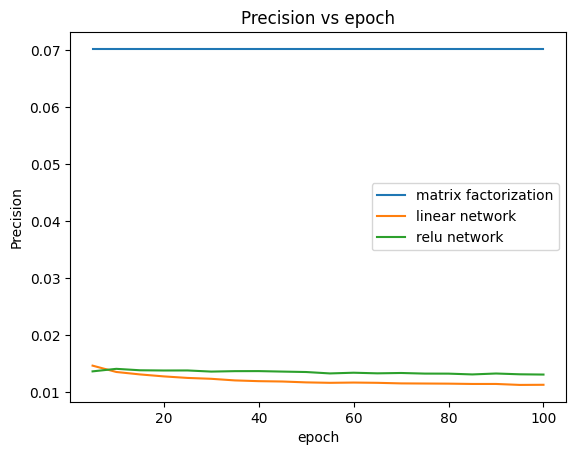

In [26]:
num_validation_runs = len(test_precision_relu)
epochs = [(x + 1)*5 for x in range(num_validation_runs)]
plt.plot(epochs, [precision_mf for i in epochs], label="matrix factorization")
plt.plot(epochs, test_precision_linear, label="linear network")
plt.plot(epochs, test_precision_relu, label="relu network")
plt.title("Precision vs epoch")
plt.xlabel("epoch")
plt.ylabel("Precision")
plt.legend();